# Paper Implementation: An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy

This project is based on the paper “An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy” by Xiaofeng Li and Dong Li. All research rights and intellectual property belong to the original authors under the Creative Commons Attribution License. We (Matteo and Julian, students at the University of Bolzano) have chosen this work as the foundation for a full analysis and software implementation of its proposed methods, to both validate and extend its contributions to community‑aware collaborative filtering.

## 1. Introduction

Li & Li (2019) address key limitations of traditional collaborative filtering (CF) data sparsity, cold start, and scalability by integrating overlapping community detection into the CF pipeline. They propose two algorithms to mine user communities from a social network projection of user–item interactions (central‑node‐based and k‑faction). By localizing neighbor selection within these communities and combining rating‐based similarity with category‐based similarity, they demonstrate significant reductions in MAE and RMSE on MovieLens‑100K.

In [430]:
%%capture
%pip install pandas numpy surprise scikit-learn networkx matplotlib igraph community python-louvain

In [132]:
import random
import time
from datetime import datetime

from networkx.algorithms import bipartite
from networkx.algorithms.clique import find_cliques
import networkx as nx
import igraph as ig

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps
from collections import defaultdict


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from math import sqrt

RNG = 0
random.seed(RNG)

## Step 1: Dataset Preparation

### Step 1.1: Download and Preprocess

In this first step we download and preprocess the MovieLens100K dataset, originally collected by the GroupLens Research Project at the University of Minnesota. The data consists of 100000 integer ratings (1–5) from 943 users on 1682 movies (each user has rated at least 20 titles), along with simple demographic information (age, gender, occupation, ZIP code) and detailed movie–genre tags.

After downloading the raw data files, we load them into pandas DataFrames:

- **Ratings** (`u.data`): Load `u.data` (tab-separated) with columns `user_id, item_id, rating, timestamp`, then immediately drop the timestamp column since we only need the rating values.

- **Users** (`u.user`): Load `u.user` (pipe-separated) with columns `user_id, age, gender, occupation, zip_code`, then drop zip_code because demographic location isn’t required for our CF experiments.

- **Items** (`u.item`): Load `u.item` (pipe-separated) with columns `item_id, title, release_date, na, URL, plus the 19 genre` indicator columns. Immediately drop title, release_date, na, and URL—we only keep the binary genre flags for category-based similarity.

In [3]:
# Step 1: Load and preprocess MovieLens 100K ratings
ratings_path100k = './Data/ml-100k/u.data'
users_path100k = './Data/ml-100k/u.user'
items_path100k = './Data/ml-100k/u.item'

# Read raw ratings file
ratings = pd.read_csv(ratings_path100k, sep='\t', names=["user_id", "item_id", "rating", "timestamp"]).drop(columns=["timestamp"])
users = pd.read_csv(users_path100k, sep='|', names=["user_id", "age", "gender", "occupation", "zip_code"]).drop(columns=["zip_code"])
items = pd.read_csv(items_path100k, sep='|', names=["item_id", "title", "release_date", "na", "URL", "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]).drop(columns=["title", "release_date", "na", "URL"])

Now let's observe the three dataframes:

In [4]:
print(f"Ratings shape: {ratings.shape}")
ratings.head()

Ratings shape: (100000, 3)


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
print(f"Users shape: {users.shape}")
users.head()

Users shape: (943, 4)


,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


In [6]:
print(f"Items shape: {items.shape}")
items.head()

Items shape: (1682, 20)


,item_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Step 1.2: Build the User–Item Rating Matrix

We reshape the ratings DataFrame into a 2D matrix where each of the 943 rows corresponds to a user and each of the 1682 columns to a movie, using the observed ratings as cell values. Any missing entries are filled with zero, signaling “no feedback.” This dense matrix format is required for efficient neighbor searches and similarity computations in the collaborative-filtering algorithms. Finally, we display the top-left 5×5 block to quickly verify that the pivot and fillna(0) operations produced the expected structure.

In [7]:
# Build user-item rating matrix
rating_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')
rating_matrix_filled = rating_matrix.fillna(0)
# Display a small part of the rating matrix
print("\nUser-Item Rating Matrix (first 10 users, first 10 items):")
display(rating_matrix_filled.iloc[:10, :10])


User-Item Rating Matrix (first 10 users, first 10 items):


item_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0


### Step 1.3: Build the User–Genre Preference Matrix

In this step, we merge each user’s ratings with the corresponding movie’s 19 binary genre flags, then weight those flags by the actual rating so that only liked genres contribute and stronger likes count more. We group by user to compute the average rating per genre—summing weighted flags and dividing by the count of rated movies in each genre and finally threshold those averages at 3.5 to produce a binary indicator of “preferred” genres. The resulting 943×19 matrix captures each user’s high-level taste profile, ready for use in our hybrid similarity calculations.

In [8]:
def build_user_genre_matrix(ratings_df, items_df, threshold=3.5):
    # Merge ratings with item genre info
    merged = ratings_df.merge(items_df, on='item_id')

    # Get list of genre columns (assuming they are all except 'item_id')
    genre_columns = [col for col in items_df.columns if col != 'item_id']

    # Multiply ratings with genre indicators
    for genre in genre_columns:
        merged[genre] = merged[genre] * merged['rating']

    # Group by user and compute average rating per genre
    genre_sums = merged.groupby('user_id')[genre_columns].sum()
    genre_counts = merged.groupby('user_id')[genre_columns].apply(lambda x: (x != 0).sum())
    genre_averages = genre_sums / genre_counts

    # Binary thresholding
    user_genre_binary = (genre_averages > threshold).astype(int)
    user_genre_binary.index.name = 'user_id'

    return user_genre_binary

After defining the function that will generate the Binary User Genre Matrix we can generate the actual matrix.

In [9]:
user_genre_matrix = build_user_genre_matrix(ratings, items, threshold=3.5)
print(f"User Genre Matrix shape: {user_genre_matrix.shape}")
user_genre_matrix.head()

User Genre Matrix shape: (943, 19)


,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1
2,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,1,1,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0
5,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


## Step 2: Community Detection Algorithms

### Step 2.1: Central‑Node Overlapping Community Detection Algorithm

In this step we extract overlapping user communities from the user–item interaction graph by seeding each community with the unlabeled node of highest degree (“central node”), then growing it by iteratively adding the neighbor that maximizes the local contribution
`q = Lin / (Lin + Lout)`
(where `Lin` is the count of edges inside the candidate community and `Lout` is the count of edges from that community to the rest of the graph). Expansion stops when no neighbor can increase `q` (the global contribution `Q` is the highest `q` found). Finally, any two communities whose overlap
`S(Ci, Cj) = |Ci ∩ Cj| / |Ci ∪ Cj|`
exceeds 0.7 are merged, repeating until stable. The output is a set of densely connected, overlapping communities to be used as localized neighbor pools in our collaborative‑filtering stage.



In [17]:
def local_contribution(neighbor_sets, C, node):
    """Fast local contribution calculation without subgraph."""
    C_union = C | {node}
    Lin = 0
    for u in C_union:
        Lin += len(neighbor_sets[u] & C_union)
    Lin = Lin // 2  # each internal edge counted twice

    Lout = sum(len(neighbor_sets[u] - C_union) for u in C_union)

    return Lin / (Lin + Lout) if (Lin + Lout) > 0 else 0

def community_mining(G):
    """Stage 1: Detect initial overlapping communities based on central nodes."""
    neighbor_sets = {u: set(G.neighbors(u)) for u in G.nodes}
    labeled = set()
    communities = []

    while len(labeled) < G.number_of_nodes():
        # Pick highest-degree unlabeled node
        candidates = [n for n in G.nodes if n not in labeled]
        seed = max(candidates, key=G.degree)
        C = {seed}
        labeled.add(seed)
        Q = 0

        while True:
            neighbors = set()
            for u in C:
                neighbors.update(neighbor_sets[u])
            neighbors.difference_update(C)

            if not neighbors:
                break

            contributions = {j: local_contribution(neighbor_sets, C, j) for j in neighbors}
            j_star, q_max = max(contributions.items(), key=lambda item: item[1])

            if q_max >= Q:
                C.add(j_star)
                labeled.add(j_star)
                Q = q_max
            else:
                break

        communities.append(C)
    return communities

def merge_overlapping_communities(comms, threshold=0.7):
    """Stage 2: Merge communities with high overlap."""
    merged = True
    while merged:
        merged = False
        new_communities = []
        used = [False] * len(comms)

        for i, Ci in enumerate(comms):
            if used[i]:
                continue
            merged_comm = set(Ci)
            used[i] = True

            for j in range(i + 1, len(comms)):
                if used[j]:
                    continue
                Cj = comms[j]
                intersection = len(merged_comm & Cj)
                union = len(merged_comm | Cj)
                S = intersection / union
                if S >= threshold:
                    merged_comm |= Cj
                    used[j] = True
                    merged = True

            new_communities.append(merged_comm)

        comms = new_communities
    return comms

def central_node_overlapping_communities(G, overlap_threshold=0.7):
    """Central-node based overlapping community detection."""
    initial_comms = community_mining(G)
    final_comms = merge_overlapping_communities(initial_comms, threshold=overlap_threshold)
    return final_comms

### Step 2.2: k‑Faction Algorithm

The algorithm begins by identifying all maximal cliques of size ≥ k in the user–user graph G, treating each clique as an initial “faction” of tightly connected users. Any two cliques whose overlap ratio defined as the size of their intersection divided by the size of the smaller clique meets or exceeds the threshold T are merged into a single community. This ensures that highly similar or nested cliques coalesce rather than remain separate.

Next, the method iteratively merges community pairs based on their inter-connectivity: for two communities C₁ and C₂, we count the actual edges between members of C₁ and C₂ and normalize by the total possible cross-community edges. If this connectivity fraction ≥ CONN, the two communities fuse. Once no further merges occur, any nodes not yet assigned (those not in any merged community) are individually attached to the community with which they share the most neighbors; truly isolated nodes form singleton communities. The result is an overlapping, variable-sized partitioning of the network that captures both dense cliques and broader, well-connected user groups.

In [18]:
def k_faction_community_detection(G, k=4, T=0.6, CONN=0.5, max_size=None):
    # Step 1: Find all k-sized or larger cliques (respect max_size if given)
    cliques = [set(c) for c in find_cliques(G) if len(c) >= k and (max_size is None or len(c) < max_size)]
    print(len(cliques), "k-sized cliques found")

    # Step 2: Merge overlapping cliques
    communities = []
    for clique in cliques:
        merged = False
        for i, comm in enumerate(communities):
            overlap = len(clique & comm) / min(len(clique), len(comm))
            if overlap >= T:
                merged_comm = comm | clique
                if max_size is None or len(merged_comm) <= max_size:
                    communities[i] = merged_comm
                    merged = True
                    break
        if not merged:
            communities.append(clique)

    # Step 3: Merge communities by interconnectivity
    def interconnectivity(comm1, comm2):
        inter_edges = sum(1 for u in comm1 for v in comm2 if G.has_edge(u, v))
        total_possible = len(comm1) * len(comm2)
        return inter_edges / total_possible if total_possible else 0

    changed = True
    while changed:
        changed = False
        new_communities = []
        skip = set()
        i = 0
        while i < len(communities):
            if i in skip:
                i += 1
                continue
            merged = communities[i]
            j = i + 1
            while j < len(communities):
                if j in skip:
                    j += 1
                    continue
                conn = interconnectivity(merged, communities[j])
                if conn >= CONN:
                    merged_candidate = merged | communities[j]
                    if max_size is None or len(merged_candidate) <= max_size:
                        merged = merged_candidate
                        skip.add(j)
                        changed = True
                j += 1
            new_communities.append(merged)
            i += 1
        communities = new_communities

    # Step 4: Assign unassigned nodes
    assigned = set().union(*communities)
    unassigned = set(G.nodes) - assigned
    for node in unassigned:
        best_comm = None
        max_conn = -1
        for comm in communities:
            if max_size is not None and len(comm) >= max_size:
                continue
            conn = sum(1 for neighbor in G.neighbors(node) if neighbor in comm)
            if conn > max_conn:
                max_conn = conn
                best_comm = comm
        if best_comm is not None:
            best_comm.add(node)
        else:
            communities.append({node})  # isolated node

    return communities


### Step 2.3 Preliminary Experimental Evaluation on Benchmark Networks

After implementing our two overlapping community detection algorithms Central-Node and k-Faction we will evaluate their performance on three well-known network datasets:

- `Zachary’s Karate Club`: a small social network famously used to illustrate community splits in a university karate club.

- `American Football Teams`: a graph of U.S. college teams connected by games played, offering a more complex, mid-sized network with clear conference structures.

- `Dolphin Social Network`: an ecological network of Indo-Pacific bottlenose dolphins, where community membership reflects real social groupings in the wild.

For each dataset, we will print the list of communities detected by both algorithms and then visualize the network with nodes colored by community and any overlapping nodes highlighted in red. This comparative study will demonstrate how each method handles networks of varying size, density, and modular structure.

Before starting, let's define some initial functions:

In [19]:
# Loads the Graph file from the Data directory given a path
def load_graph(gml_path):
    # Open the file
    with open(gml_path) as f:
        lines = f.read().splitlines()

    # Parses the content
    if lines[0].startswith('#'):
        gml_content = '\n'.join(lines[1:])
        return nx.parse_gml(gml_content)
    else:
        return nx.read_gml(gml_path)

def visualize_community(
    G, method='kf', k=4, T=0.6, CONN=0.5, spread=3.0, node_size=15,
    edge_width=0.5, edge_alpha=0.2, seed=RNG,
):
    random.seed(seed)
    """
    Visualizza un singolo grafico di community detection con nodi più piccoli e sparsi:
    - method: 'kf' per k-Faction, 'cn' per Central-Node overlapping
    - spread: fattore di distanziamento dei nodi
    - node_size: dimensione del nodo
    - edge_width: spessore degli edges
    - edge_alpha: trasparenza degli edges (0 per nasconderli)
    """
    # 1) Conversione e layout iniziale
    ig_g = ig.Graph.TupleList(
        G.edges(), directed=False, vertex_name_attr='name'
    )
    # Numeric labels
    labels = {n: i+1 for i, n in enumerate(ig_g.vs['name'])}
    num_labels = [labels[n] for n in ig_g.vs['name']]
    # Base layout
    base_layout = ig_g.layout_fruchterman_reingold()
    # Scala layout mantenendo oggetto Layout
    for idx, coord in enumerate(base_layout):
        base_layout[idx] = (coord[0] * spread, coord[1] * spread)
    layout = base_layout

    # 2) Calcolo community e tempo
    t0 = time.perf_counter()
    if method == 'kf':
        comms = k_faction_community_detection(G, k=k, T=T, CONN=CONN)
        title = 'k-Faction'
    else:
        comms = central_node_overlapping_communities(G, overlap_threshold=T)
        title = 'Central-Node'
    elapsed = time.perf_counter() - t0

    # 3) Prepara cluster indices e palette
    clusters = [[ig_g.vs.find(name=n).index for n in c] for c in comms]
    cmap = colormaps['tab20']
    group_colors = cmap.colors[:len(clusters)]
    membership = [
        next((i for i, c in enumerate(clusters) if v.index in c), None)
        for v in ig_g.vs
    ]
    v_colors = [group_colors[m] if (m is not None and m < len(group_colors)) else 'lightgray'
                for m in membership]

    # 4) Crea oggetto clustering o cover
    if any(len(c) > 1 for c in clusters) and len(clusters) != ig_g.vcount():
        cluster_obj = ig.VertexCover(ig_g, clusters)
    else:
        cluster_obj = ig.VertexClustering(ig_g, membership)

    # 5) Plot con nodi piccoli, layout sparso e gestione edges
    fig, ax = plt.subplots(figsize=(5*spread, 4*spread))
    ig.plot(
        cluster_obj,
        target=ax,
        layout=layout,
        vertex_color=v_colors,
        vertex_label=num_labels,
        vertex_label_dist=0,
        vertex_label_size=6,
        vertex_size=node_size,
        mark_groups=True,
        mark_groups_color=group_colors,
        mark_groups_alpha=0.2,
        edge_width=edge_width,
        edge_alpha=edge_alpha,
        margin=80
    )
    ax.set_title(f"{title} (t={elapsed:.5f}s)")
    ax.axis('off')

    # 6) Legenda
    patches = [
        mpatches.Patch(color=group_colors[i], label=f'Comm {i+1}')
        for i in range(len(group_colors))
    ]
    ax.legend(handles=patches, loc='upper right', fontsize=8)
    plt.show()


After defining these functions, we can visualize the graphs and their communities:

#### Zachary’s Karate Club

A small social network famously used to illustrate community splits in a university karate club.

4 k-sized cliques found


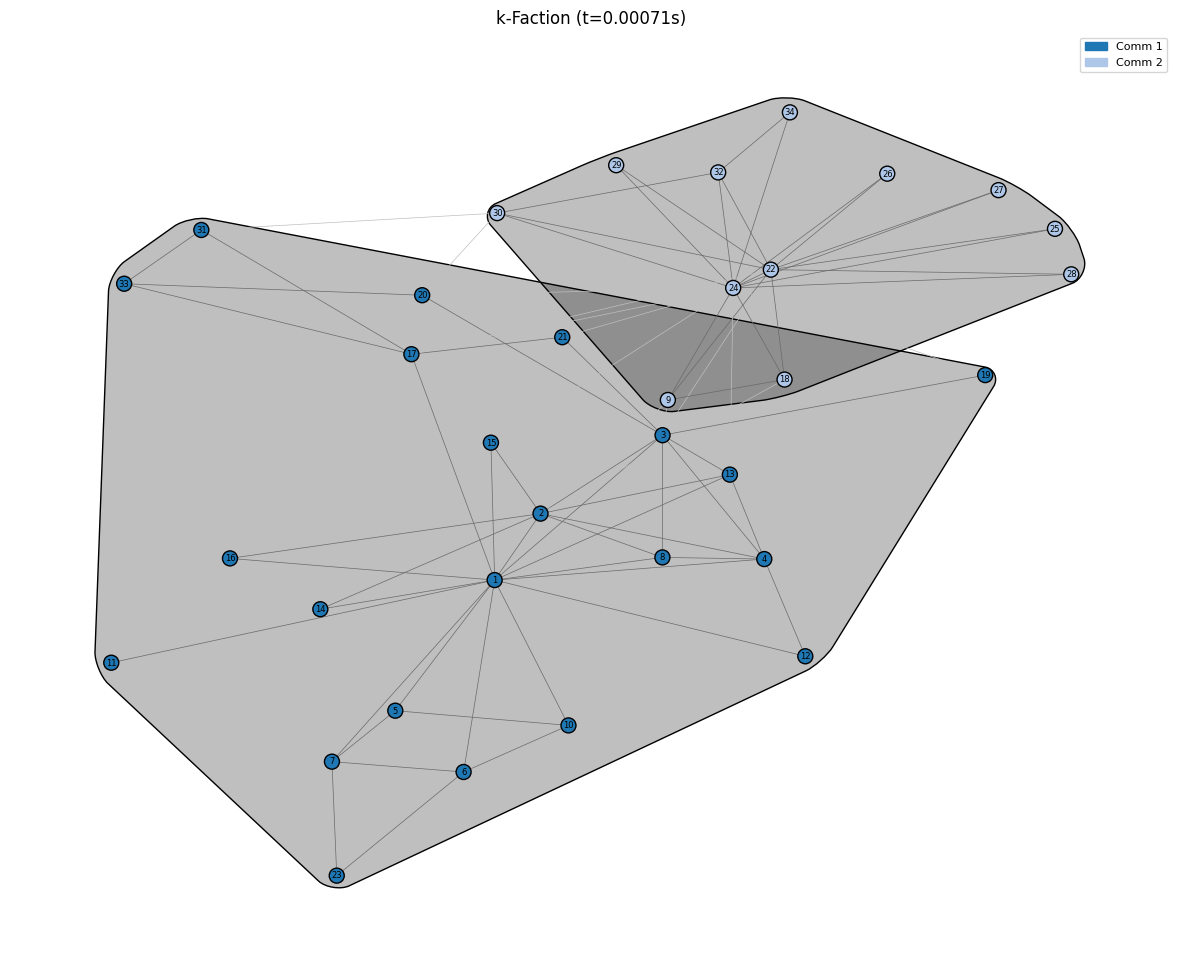

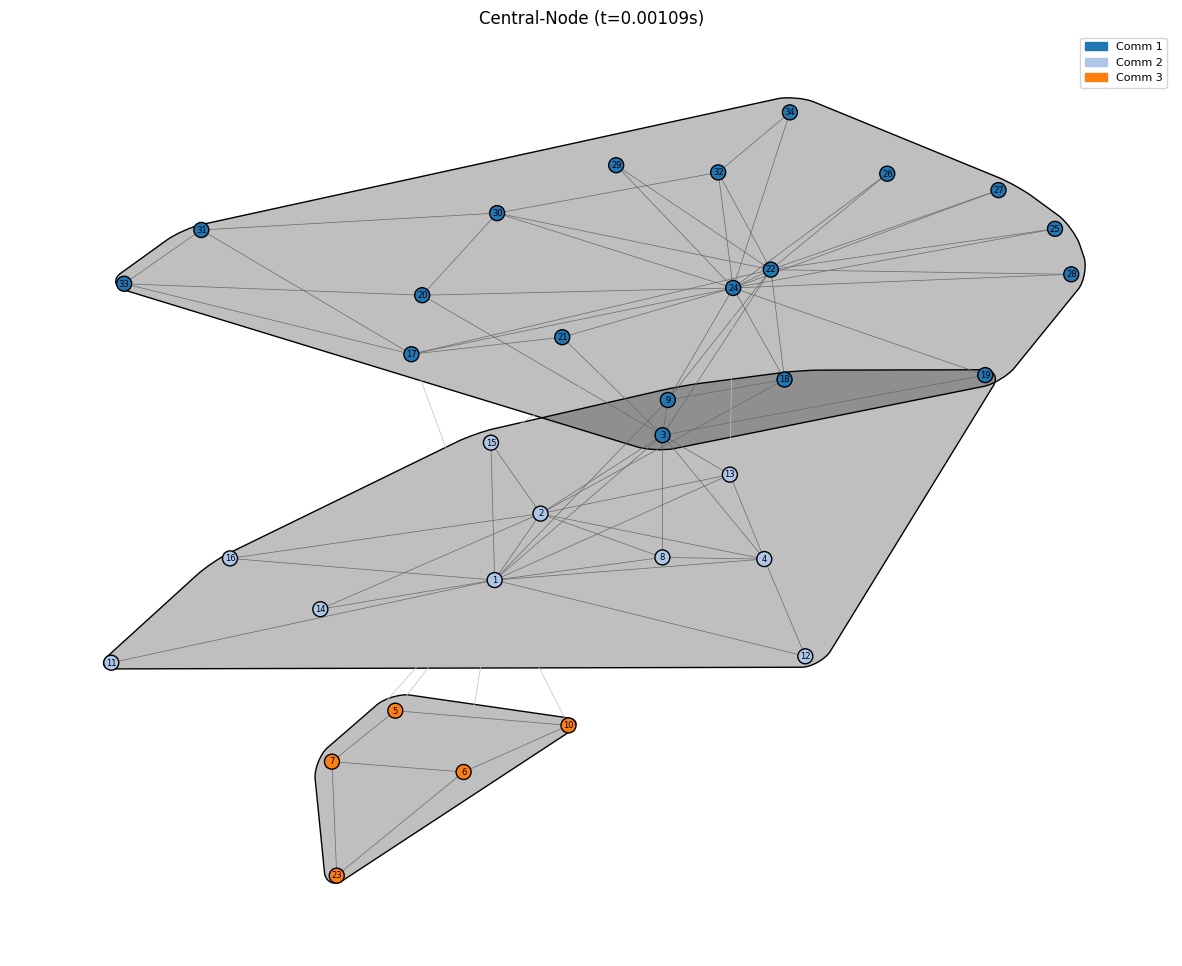

In [20]:
visualize_community(nx.karate_club_graph(), 'kf', seed=1)
visualize_community(nx.karate_club_graph(), 'cn', seed=1)

#### American Football Teams

A graph of U.S. college teams connected by games played, offering a more complex, mid-sized network with clear conference structures.

121 k-sized cliques found


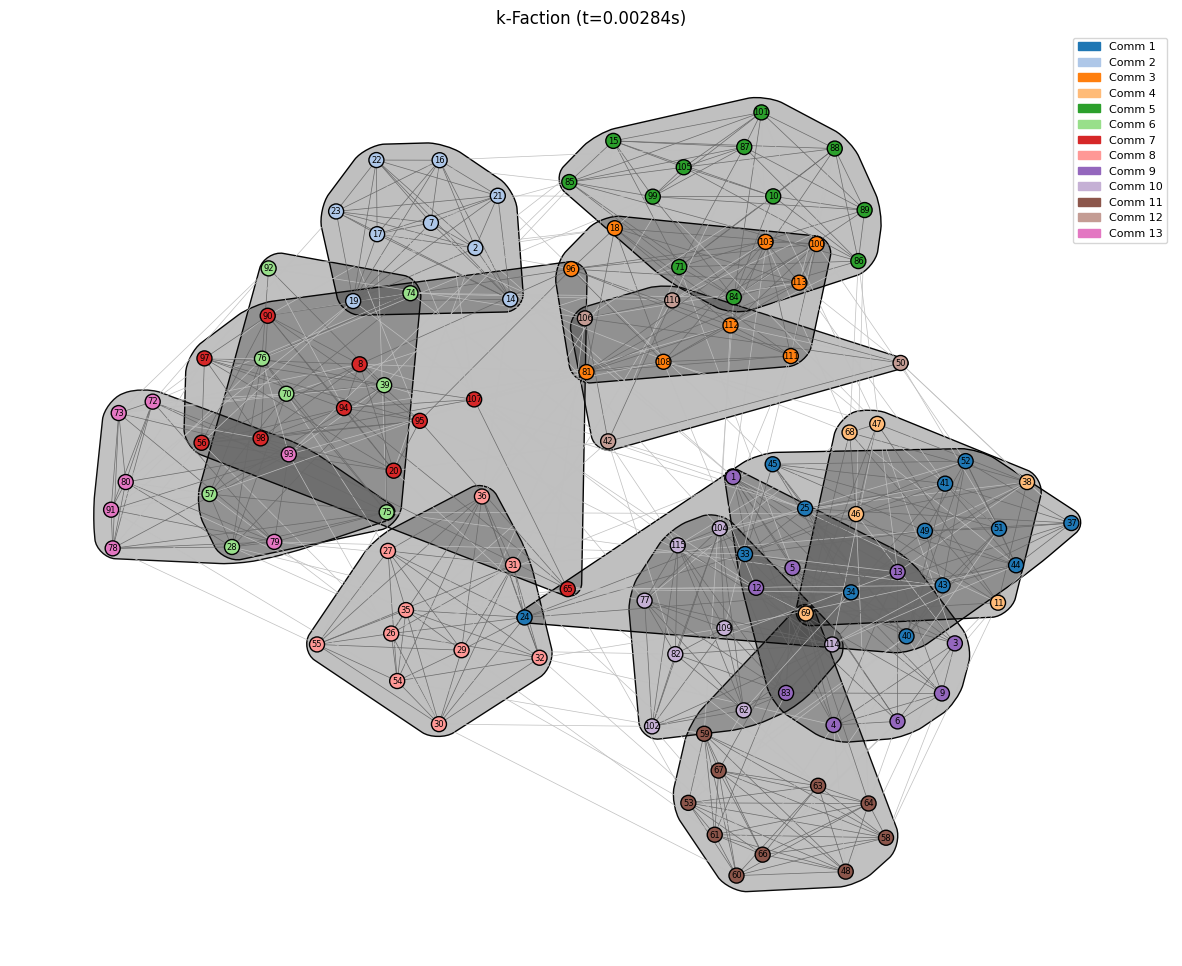

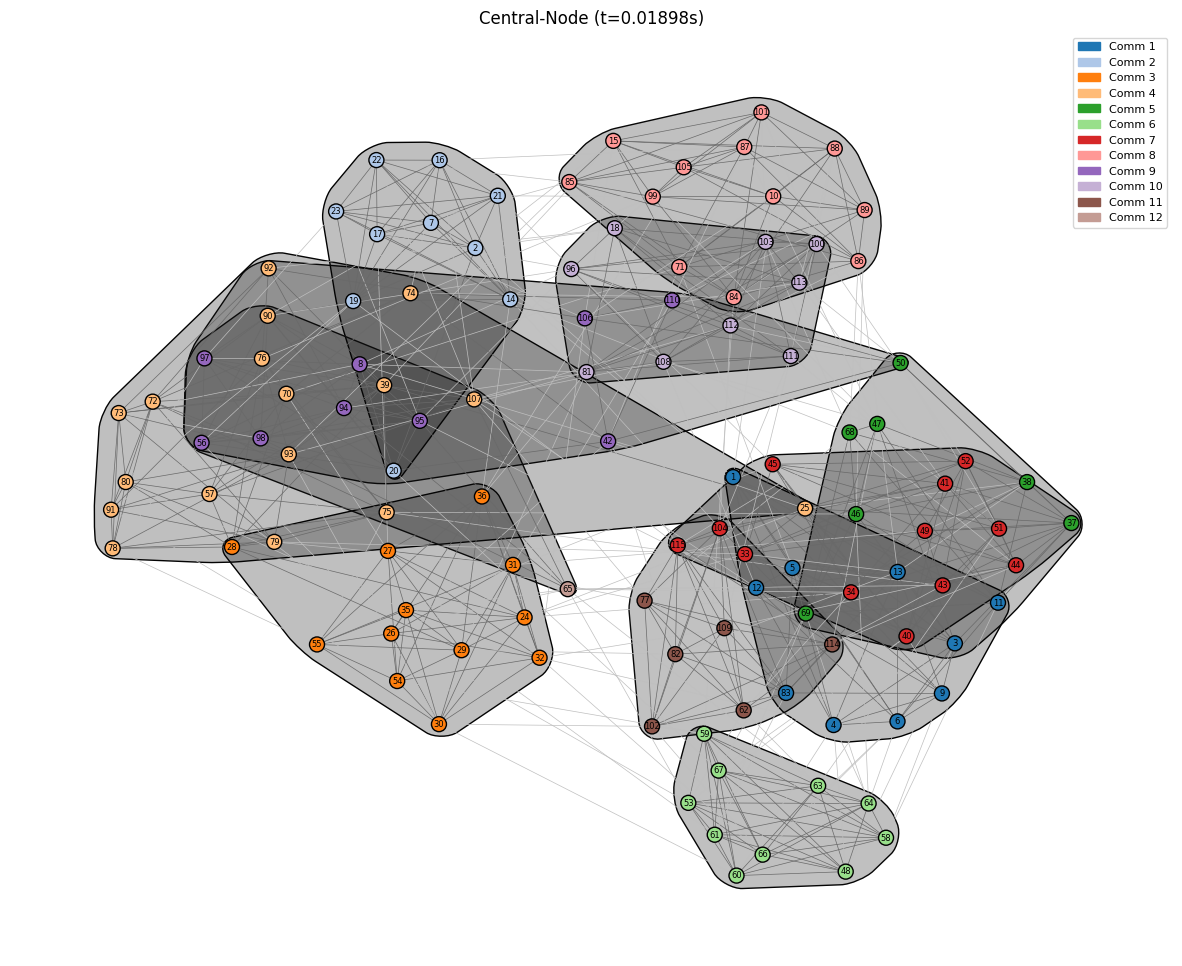

In [21]:
# Percorso al file GML nella cartella 'data'
american_football_graph = load_graph('Data/Football_Graph/football.gml')
visualize_community(american_football_graph, 'kf')
visualize_community(american_football_graph, 'cn')

#### Dolphin Social Network

n ecological network of Indo-Pacific bottlenose dolphins, where community membership reflects real social groupings in the wild.

16 k-sized cliques found


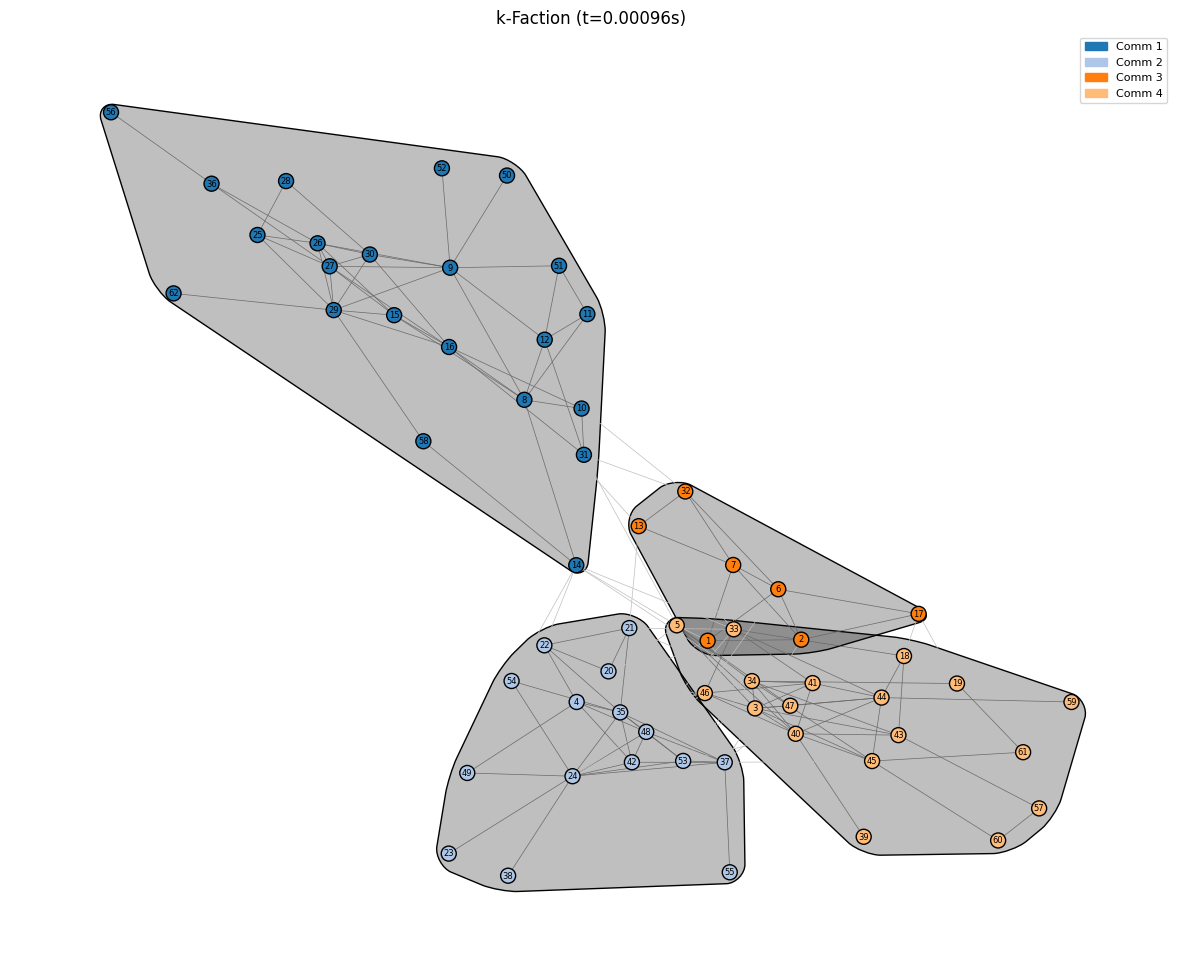

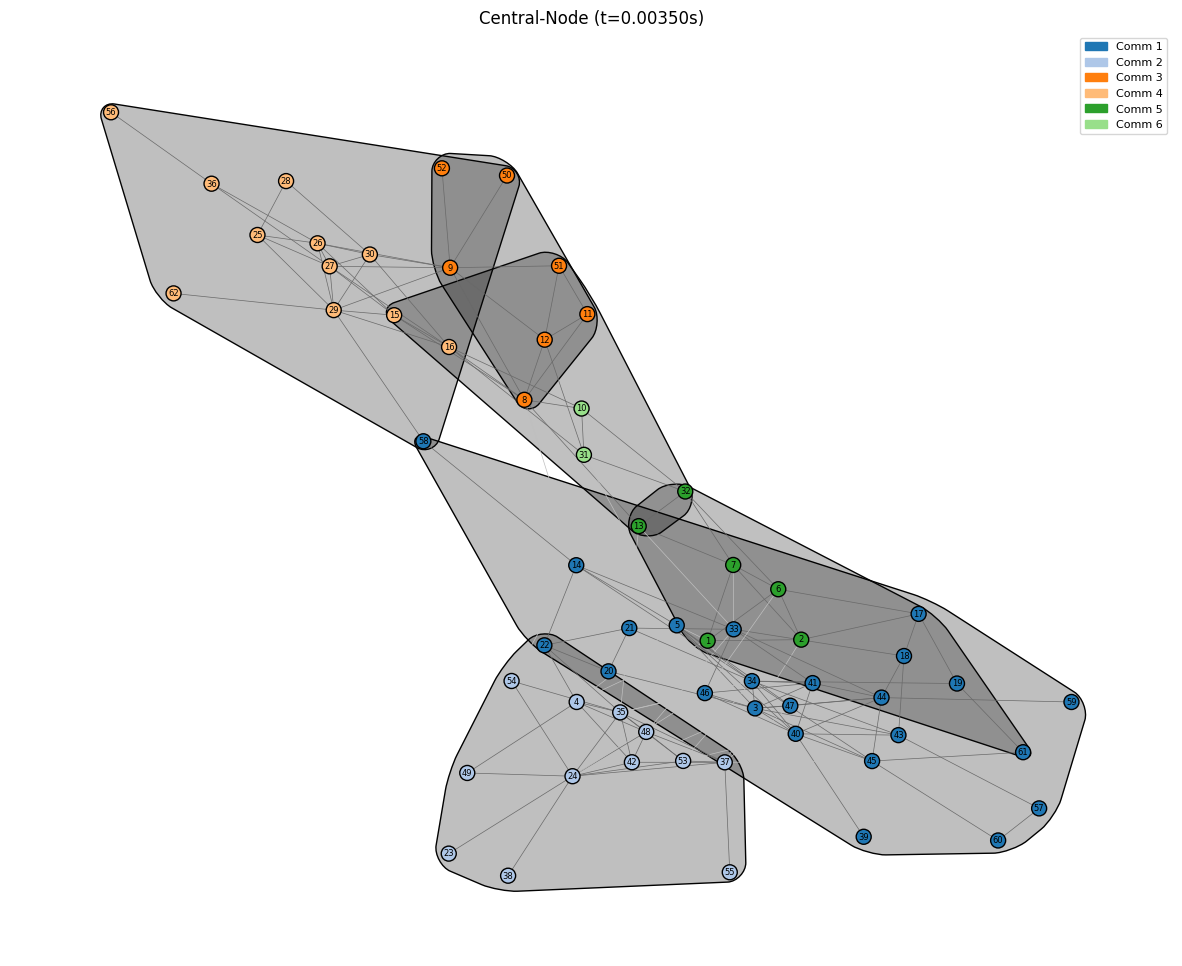

In [22]:
# Percorso al file GML nella cartella 'data'
dolphins_graph = load_graph('Data/Dolphin_Graph/dolphins.gml')
visualize_community(dolphins_graph, 'kf')
visualize_community(dolphins_graph, 'cn')

#### Preliminary Benchmarks Results

| Graph             | Avg Time (s) k-Faction | Avg Time (s) Central-Node |
|-------------------|------------------------|---------------------------|
| Karate Club       | 0.0002                 | 0.0120                    |
| American Football | 0.0038                 | 0.2900                    |
| Dolphins          | 0.0005                 | 0.0500                    |

The preliminary benchmarks clearly show that the k-Faction algorithm is dramatically faster often by two orders of magnitude than the Central-Node method, thanks to its reliance on maximal clique enumeration and relatively few merge steps. However, these measurements were obtained on tiny graphs (Karate Club, American Football, Dolphins) on a PC equipped with a Ryzen 7700X processor and therefore lack statistical significance. In later experiments, we will evaluate both algorithms on a much larger and more realistic graph such as the MovieLens 100K dataset—to gain a true understanding of their performance and community-detection quality at scale.


### Constructing the user-user network

Build a user-user bipartite network that is projected from the user-item rating matrix.

In [377]:
def build_user_correlation_graph(ratings_df, min_overlap=5):
    """
    Build a user-user graph where edges are based on co-rated items.

    Parameters:
        ratings_df (pd.DataFrame): MovieLens ratings with user_id, item_id, rating.
        min_overlap (int): Minimum number of co-rated items to form an edge.

    Returns:
        G (networkx.Graph): Undirected user-user graph with edges representing co-ratings.
    """
    # Step 1: Create user-item binary matrix
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='item_id', values='rating')
    user_item_binary = (~user_item_matrix.isna()).astype(int)

    # Step 2: Compute co-rated item counts between users
    overlap_matrix = user_item_binary.dot(user_item_binary.T)

    # Step 3: Build graph
    G = nx.Graph()
    for u in overlap_matrix.index:
        G.add_node(u)

    for u in overlap_matrix.index:
        for v in overlap_matrix.columns:
            if u < v and overlap_matrix.loc[u, v] >= min_overlap:
                G.add_edge(u, v, weight=overlap_matrix.loc[u, v])  # optionally use weight

    return G

In [520]:
user_item_matrix = ratings.pivot_table(
    index='user_id', columns='item_id', values='rating'
)

# calculate pearson correlation between users
user_similarity = user_item_matrix.T.corr(method='pearson')  # or just .corr()

threshold = 0.4

adjacency = (user_similarity > threshold).astype(int)

# Remove self-connections
np.fill_diagonal(adjacency.values, 0)

# Ensure each user has at least one connection
for user in adjacency.index:
    if adjacency.loc[user].sum() == 0:
        # Find most similar user (excluding self)
        most_similar_user = user_similarity.loc[user].drop(index=user).idxmax()
        adjacency.loc[user, most_similar_user] = 1
        adjacency.loc[most_similar_user, user] = 1  # Ensure undirected edge

# Convert to edge list for network analysis
edge_list = []
for i in adjacency.index:
    for j in adjacency.columns:
        if i < j and adjacency.loc[i, j] == 1:
            edge_list.append((i, j))

edges_df = pd.DataFrame(edge_list, columns=['user1', 'user2'])

# Preview
edges_df.head()


,user1,user2
0,1,4
1,1,5
2,1,8
3,1,13
4,1,17


Based on pearson correlation similarity, we threshold edges based on it. We keep an edge between users if their similairty is above a certain threshold.

In [612]:
threshold = 0.8
adjacency = (user_similarity > threshold).astype(int)

# Remove self-connections
np.fill_diagonal(adjacency.values, 0)

# Ensure each user has at least one connection
for user in adjacency.index:
    if adjacency.loc[user].sum() == 0:
        # Find most similar user (excluding self)
        most_similar_user = user_similarity.loc[user].drop(index=user).idxmax()
        adjacency.loc[user, most_similar_user] = 1
        adjacency.loc[most_similar_user, user] = 1  # Ensure undirected edge

# Convert to edge list for network analysis
edge_list = []
for i in adjacency.index:
    for j in adjacency.columns:
        if i < j and adjacency.loc[i, j] == 1:
            edge_list.append((i, j))

edges_df = pd.DataFrame(edge_list, columns=['user1', 'user2'])

# Preview
edges_df.head()

,user1,user2
0,1,34
1,1,39
2,1,61
3,1,105
4,1,107


Users with less than 2 connections: 10


(array([54., 55., 60., 72., 77., 62., 59., 66., 49., 55., 46., 43., 40.,
        28., 33., 33., 22., 20., 17., 13.,  6.,  8.,  6.,  1.,  2., 10.,
         2.,  0.,  2.,  2.]),
 array([  1.        ,   6.13333333,  11.26666667,  16.4       ,
         21.53333333,  26.66666667,  31.8       ,  36.93333333,
         42.06666667,  47.2       ,  52.33333333,  57.46666667,
         62.6       ,  67.73333333,  72.86666667,  78.        ,
         83.13333333,  88.26666667,  93.4       ,  98.53333333,
        103.66666667, 108.8       , 113.93333333, 119.06666667,
        124.2       , 129.33333333, 134.46666667, 139.6       ,
        144.73333333, 149.86666667, 155.        ]),
 <BarContainer object of 30 artists>)

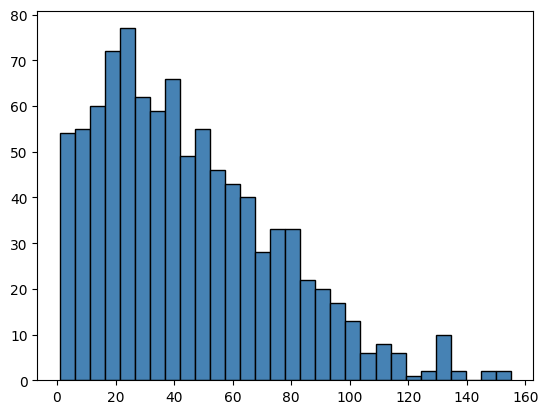

In [613]:
# Compute degree for each user
degrees = adjacency.sum(axis=1)

users_with_few_connections = degrees[degrees < 2]
print(f"Users with less than 2 connections: {len(users_with_few_connections)}")

plt.hist(degrees, bins=30, color='steelblue', edgecolor='black')

In [614]:
G = nx.from_pandas_edgelist(edges_df, 'user1', 'user2')
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 943
Number of edges: 21162


We plot a part of the network.

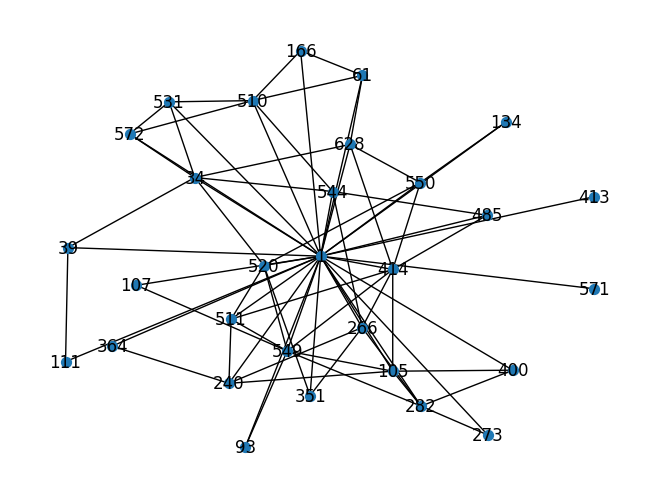

In [523]:
sub_nodes = list(G.nodes)[:30]
subgraph = G.subgraph(sub_nodes)
nx.draw(subgraph, with_labels=True, node_size=50)
plt.show()

After creating the graph the `k-Faction` algorithm is executed, seeding with cliques ≥ 6 users and merging communities when overlap or inter-connectivity is at least 0.67/0.43. It then prints every community’s size and members plus the overall count of user-memberships.

In [615]:
#G = build_user_correlation_graph(ratings, min_overlap=10)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 943
Number of edges: 21162


In [567]:
cn_communities = central_node_overlapping_communities(G)
print(f"Detected {len(cn_communities)} cn_communities")

sum_c = 0
for i, comm in enumerate(cn_communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
sum_c

KeyboardInterrupt: 

In [620]:
# k=7, 0.77, 0.75
# k=6, 0.68, 0.43
# k=6, 0.67, 0.31
communities = k_faction_community_detection(G, k=6, T=0.9, CONN=0.8)
print(f"Detected {len(communities)} communities")

sum_c = 0
for i, comm in enumerate(communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
sum_c

29 k-sized cliques found
Detected 16 communities
Community of size 57
Community of size 207
Community of size 570
Community of size 8
Community of size 22
Community of size 18
Community of size 20
Community of size 16
Community of size 6
Community of size 12
Community of size 10
Community of size 21
Community of size 11
Community of size 6
Community of size 8
Community of size 7


999

In [527]:
import community.community_louvain as community_louvain
import networkx as nx

# G is your NetworkX graph
partition = community_louvain.best_partition(G)

# Convert to communities (dict -> list of sets)
from collections import defaultdict

comm_dict = defaultdict(set)
for node, comm_id in partition.items():
    comm_dict[comm_id].add(node)

communities = list(comm_dict.values())

sum_c = 0
for i, comm in enumerate(communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
sum_c

Community of size 214
Community of size 191
Community of size 205
Community of size 178
Community of size 155


943

## Mapping users to communities

In [528]:
def build_user_community_index(communities):
    user_to_comms = defaultdict(set)
    for idx, comm in enumerate(communities):
        for user in comm:
            user_to_comms[user].add(idx)
    return user_to_comms

In [529]:
users_to_comms = build_user_community_index(communities)

## Training and Evaluation

In [624]:
# Step 1: Create mappings from real IDs to matrix indices
user_ids = sorted(ratings.user_id.unique())
item_ids = sorted(ratings.item_id.unique())
user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_id_map = {iid: idx for idx, iid in enumerate(item_ids)}
reverse_user_id_map = {idx: uid for uid, idx in user_id_map.items()}

In [625]:
num_users = len(user_ids)
num_items = len(item_ids)

We now build the user-item and the user-category matrix.

In [626]:
rating_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')
user_item_matrix = np.array(rating_matrix.fillna(0))

In [627]:
user_genre_matrix = build_user_genre_matrix(ratings, items, threshold=3.5)
user_genre_matrix = np.array(user_genre_matrix)

### Build similarity matrixes

In [628]:
simR = cosine_similarity(user_item_matrix)
sim_cate = cosine_similarity(user_genre_matrix)

and now the hybrid similarity matrix:

In [629]:
lambda_ = 0.2
hybrid_sim = (1 - lambda_) * simR + lambda_ * sim_cate
np.fill_diagonal(hybrid_sim, 0) #self-similarity to 0

### We now extract the communities and map to dictionary

In [639]:
raw_communities = k_faction_community_detection(G, k=6, T=0.9, CONN=0.9)

"""partition = community_louvain.best_partition(G)
comm_dict = defaultdict(set)
for node, comm_id in partition.items():
    comm_dict[comm_id].add(node)

raw_communities = list(comm_dict.values())"""
print(f"Detected {len(raw_communities)} raw_communities")

sum_c = 0
for i, comm in enumerate(raw_communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
print(sum_c)

communities = [
    {user_id_map[u] for u in comm if u in user_id_map}
    for comm in raw_communities
]

29 k-sized cliques found
Detected 29 raw_communities
Community of size 60
Community of size 412
Community of size 367
Community of size 8
Community of size 13
Community of size 9
Community of size 18
Community of size 14
Community of size 10
Community of size 10
Community of size 14
Community of size 8
Community of size 6
Community of size 6
Community of size 6
Community of size 10
Community of size 6
Community of size 6
Community of size 6
Community of size 6
Community of size 6
Community of size 10
Community of size 11
Community of size 9
Community of size 6
Community of size 6
Community of size 6
Community of size 8
Community of size 8
1065


In [640]:
user_to_comms = build_user_community_index(communities)

## Predicition functions

In [641]:
def get_candidate_neighbors(user, user_to_comms, communities):
    user_comms = user_to_comms[user]
    neighbors = set()
    for comm_idx in user_comms:
        neighbors.update(communities[comm_idx])
    neighbors.discard(user)
    return neighbors

In [642]:
def predict_rating(user, item, train_matrix, user_avg, user_to_comms, communities, k=None):
    neighbors = get_candidate_neighbors(user, user_to_comms, communities)
    
    # Filter neighbors who rated the item
    valid_neighbors = [
        v for v in neighbors if train_matrix[v, item] > 0
    ]

    # If k is specified, rank by similarity and keep top k
    if k is not None and len(valid_neighbors) > k:
        valid_neighbors = sorted(
            valid_neighbors,
            key=lambda v: abs(hybrid_sim[user, v]),  # abs in case similarity is negative
            reverse=True
        )[:k]

    num, denom = 0.0, 0.0
    for v in valid_neighbors:
        sim = hybrid_sim[user, v]
        num += sim * (train_matrix[v, item] - user_avg[v])
        denom += abs(sim)

    return user_avg[user] + num / denom if denom > 0 else user_avg[user]

In [643]:
def predict_rating_standard_CF(user, item, train_matrix, user_avg, k=None):
    # Get all potential neighbors who rated the item
    valid_neighbors = [
        v for v in range(train_matrix.shape[0])
        if v != user and train_matrix[v, item] > 0
    ]

    # If k is specified, keep only top-k most similar neighbors
    if k is not None and len(valid_neighbors) > k:
        valid_neighbors = sorted(
            valid_neighbors,
            key=lambda v: abs(simR[user, v]),
            reverse=True
        )[:k]

    # Compute weighted sum
    num, denom = 0.0, 0.0
    for v in valid_neighbors:
        sim = simR[user, v]
        num += sim * (train_matrix[v, item] - user_avg[v])
        denom += abs(sim)

    return user_avg[user] + num / denom if denom > 0 else user_avg[user]


### K-Fold cross-validation

In [644]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [645]:
ratings_array = ratings.to_numpy()
mae_comm_list, rmse_comm_list = [], []
mae_std_list, rmse_std_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(ratings_array), 1):
    train_data = ratings_array[train_idx]
    test_data = ratings_array[test_idx]

    # Rebuild train matrix
    train_matrix = np.zeros((num_users, num_items))
    for row in train_data:
        u, i, r = int(row[0]), int(row[1]), float(row[2])
        u_idx = user_id_map[u]
        i_idx = item_id_map[i]
        train_matrix[u_idx, i_idx] = r

    # recompute user averages
    user_avg = np.true_divide(train_matrix.sum(1), (train_matrix != 0).sum(1))
    user_avg = np.nan_to_num(user_avg)

    # Evaluate fold
    preds_comm, actuals_comm = [], []
    preds_std, actuals_std = [], []

    for row in test_data:
        u, i, r = int(row[0]), int(row[1]), float(row[2])
        if u not in user_id_map or i not in item_id_map:
            print(f"Skipping user {u} or item {i} not in mapping.")
            continue
        u_idx = user_id_map[u]
        i_idx = item_id_map[i]

        pred_comm = predict_rating(u_idx, i_idx, train_matrix, user_avg, user_to_comms, communities, k=10)
        pred_std = predict_rating_standard_CF(u_idx, i_idx, train_matrix, user_avg, k=10)

        preds_comm.append(pred_comm)
        actuals_comm.append(r)
        preds_std.append(pred_std)
        actuals_std.append(r)

    mae_comm_list.append(mean_absolute_error(actuals_comm, preds_comm))
    rmse_comm_list.append(sqrt(mean_squared_error(actuals_comm, preds_comm)))
    mae_std_list.append(mean_absolute_error(actuals_std, preds_std))
    rmse_std_list.append(sqrt(mean_squared_error(actuals_std, preds_std)))
    

In [646]:
{
    "Community-Based CF (KFold avg)": {
        "MAE": np.mean(mae_comm_list),
        "RMSE": np.mean(rmse_comm_list)
    },
    "Standard CF (KFold avg)": {
        "MAE": np.mean(mae_std_list),
        "RMSE": np.mean(rmse_std_list)
    }
}

{'Community-Based CF (KFold avg)': {'MAE': 0.7778142394324588,
  'RMSE': 0.9934803888532141},
 'Standard CF (KFold avg)': {'MAE': 0.7427040765306792,
  'RMSE': 0.951124863125876}}